## Exploratory Analysis

### Overview
In this notebook, we explore the dataset and the available features, aiming to establish a clear framework for the subsequent time series modeling task.

### Key Findings
1. **Relevant Columns**:
   - The primary columns for time series modeling are `SKU` and `Quantity_sold`.
   - `current_level`  while constant within an SKU, varies across SKUs and shows a significant correlation with the average `Quantity_sold` per `SKU` , it can be helpful for our task

2. **Handling Missing Dates**:
   - We assume that the absence of a date indicates no quantity sold (i.e., `Quantity_sold = 0`).

### Time Series Analysis
- **Visualization**:
  - We visualize a few random samples to explore short-term and long-term patterns.
- **Correlation Analysis**:
  - Initial correlation analysis provided insights into cross-SKU similarities, helping identify very similar SKUs.

### Next steps : 
- Explore delayed cross-SKU correlations (e.g., `corr(SKU(i, t), SKU(j, t-1))`) to identify if a leading SKU exists. This concept is known as Granger Causality.
- Fourier analysis 


### Modeling Framework
The time series exhibits both short-term and long-term patterns, which can be visualized in the notebook. In the absence of specific business constraints, we set up the following framework:
- **Data Aggregation**:
  - Aggregate data weekly to denoise and reinforce patterns.
- **Observation Updates**:
  - Assume observations are updated every 4 weeks.
  - The task is to predict the next 4 weeks given an initial 4-week observation, then move along the history, enriching it every 4 steps.
- **SKU-level Modeling**:
  - An SKU-level model may struggle initially but could converge after a few iterations.
- **Cross-SKU Patterns**:
  - Long-term cross-SKU patterns show repetitive profiles, suggesting that a model trained on combined SKUs can work.
  - The assumption is that a sufficiently large and representative dataset will build a knowledge base on inventory behaviors, with each SKU expressed as a combination of different SKUs; We expect the likelihood of an `SKU` displaying a new and unique behaviour to be very small .

### Chosen Approach
After exploring simple approaches like moving average, replicating the latest year's behavior, and ARIMA, we chose a Seq2Seq approach using an encoder-decoder architecture with attention , details in `modelling_experiments.ipynb`

### Evaluation Metric
- **Mean Absolute Percentage Error (MAPE)**:
  - Use MAPE as the comparison metric.
  - Calculate the mean on the SKU level, then track quantiles ([0, .25, .5, .85, .95, 1]) instead of averaging across SKUs.
  - This approach provides better visibility and helps make trade-offs, such as accepting high-quality predictions for a small set and lower quality for the rest, versus average quality for all.

### Benchmarks
We benchmark the chosen Seq2Seq approach against:
- ARIMA
- Vanilla GRU
- Temporal Convolutional Network (TCN)
- LagLlama


In [3]:
import pandas as pd 
import numpy as np 

In [2]:
LOOKBACK = 6
HORIZON = 12
INPUT_COL = f"past_{LOOKBACK}_months"
OUTPUT_COL = f"past_{HORIZON}_months"
START_MONTH = "startMonth"
WEEKOFYEAR = "weekOfYear"
LISTWEEKSOFYEAR = f"list{WEEKOFYEAR}"
TARGET_WEEKS = "targetWeeks"
TARGET = 'QUANTITY_SOLD'
IDCOL = 'SKU'
DATECOL = 'DATE'
CLEANTARGET = f'clean_{TARGET}'
MONTHCOL = "month"
YEARCOL = "year"
TARGETYEAR = "listed_year"
TARGETYEAR_1 = "listed_year_1"
STATICOL="CURRENT_LEVEL"
LISTCLEANTARGET=f'list_{CLEANTARGET}'
DEPTHISTORYDAYS = 'depthHistorySku'
MINDEPTHISTORYMONTHS = 18 #(6 months input , 12 output) - Arbitrary , can be reduced later if patterns are very explicit
MINDEPTHISTORYDAYS = MINDEPTHISTORYMONTHS*31
LISTMONTHS = "listMonths"
INPUT_SEQUENCE="inputSeq"
OUTPUT_SEQUENCE="outputSeq"
NORM_STATICOL = f"normalized{STATICOL}"

## Explore dataset and clean


In [4]:
df=pd.read_csv("../datasets/data.csv")
df[DATECOL]=pd.to_datetime(df[DATECOL])
df.head()

,STORE,DATE,SKU,QUANTITY_SOLD,CURRENT_LEVEL
0,mystore,2024-04-03,636723034103246386,1,30
1,mystore,2023-06-12,636723034103246386,1,30
2,mystore,2023-07-22,636723034103246386,1,30
3,mystore,2023-11-17,636723034103246386,2,30
4,mystore,2024-02-26,636723034103246386,1,30


In [5]:
# Current level does not change , we'll assume it's a static column , we'll explore how useful it can be for our task 
df.groupby(IDCOL)[STATICOL].nunique().unique(
)

array([1])

In [6]:
df['STORE'].unique()

array(['mystore'], dtype=object)

In [7]:
df.drop('STORE',axis=1,inplace=True)

- Current level does not change , we'll assume it's a static column , we'll explore how useful it can be for our task 
- STORE is not relevant

In [8]:
df[TARGET].quantile([0,.25,.65,.85,.95,.99,1])

0.00        0.0
0.25        1.0
0.65        4.0
0.85        8.0
0.95       20.0
0.99       60.0
1.00    10040.0
Name: QUANTITY_SOLD, dtype: float64

<Axes: >

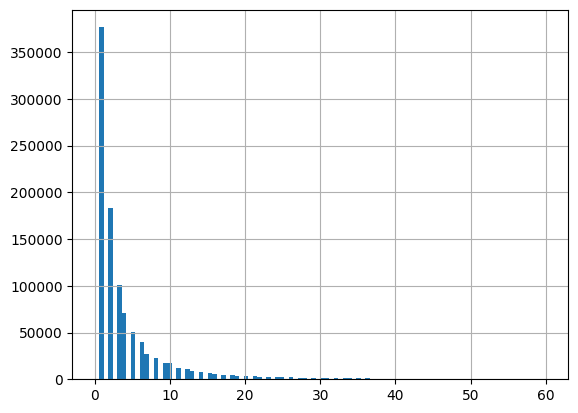

In [9]:
df[df[TARGET]<=60][TARGET].hist(bins=100)

In [10]:
df[df[TARGET]<=60].groupby([IDCOL,STATICOL],as_index=False)[TARGET].mean().head()

,SKU,CURRENT_LEVEL,QUANTITY_SOLD
0,-9222467576456937548,110,1.355932
1,-9209598084102175757,160,3.145963
2,-9205287583597695299,7009,4.291105
3,-9204707410569096277,1061,6.065574
4,-9200103262617068331,321,2.394737


In [11]:
df[df[TARGET]<=60].groupby([IDCOL,STATICOL],as_index=False)[TARGET].mean()[[TARGET,STATICOL]].corr()

,QUANTITY_SOLD,CURRENT_LEVEL
QUANTITY_SOLD,1.000000,0.433813
CURRENT_LEVEL,0.433813,1.000000


- Current level seems to be significantly correlated with the average quantity sold per SKU , it can be useful depending on the model architecture we use

In [12]:
df.drop_duplicates(['SKU','DATE']).shape , df.shape # no duplicates

((1026036, 4), (1026036, 4))

In [13]:
# Let's do a customised quantile clipping
indiv_quantiles = df.groupby(IDCOL)[TARGET].quantile([.02,.98]).reset_index().pivot_table(index=[IDCOL],columns=['level_1'],values=[TARGET]).reset_index()
indiv_quantiles .columns = [IDCOL,'quantile_02','quantile_98']
indiv_quantiles.head()

,SKU,quantile_02,quantile_98
0,-9222467576456937548,1.0,4.00
1,-9209598084102175757,1.0,10.00
2,-9205287583597695299,1.0,15.00
3,-9204707410569096277,1.0,29.06
4,-9200103262617068331,1.0,8.00


In [14]:
df =indiv_quantiles.merge(df).reset_index(drop=True)
# set nan if value is an outlier , with respect to the SKU normal range
df= df.sort_values([IDCOL,DATECOL]).reset_index(drop=True)
df[CLEANTARGET] = df.apply(lambda x : np.nan if (x[TARGET]<x['quantile_02']) or (x[TARGET]>x['quantile_98']) else x[TARGET],axis=1)
# interpolate nans
df[CLEANTARGET] = df.groupby(IDCOL)[CLEANTARGET].apply(lambda  x: x.interpolate(method='linear')).reset_index()[CLEANTARGET]


In [15]:
hist_distr = df.groupby(IDCOL,as_index=False).agg({DATECOL:["min","max"]})
hist_distr.columns = [IDCOL,f"min{DATECOL}",f"max{DATECOL}"]
hist_distr["depthHistory"] = (hist_distr[f"max{DATECOL}"]-hist_distr[f"min{DATECOL}"]).dt.days
hist_distr.head()

,SKU,minDATE,maxDATE,depthHistory
0,-9222467576456937548,2022-03-15,2024-05-23,800
1,-9209598084102175757,2023-04-05,2024-05-23,414
2,-9205287583597695299,2023-02-10,2024-05-23,468
3,-9204707410569096277,2016-02-07,2024-05-23,3028
4,-9200103262617068331,2023-10-27,2024-05-21,207


<Axes: >

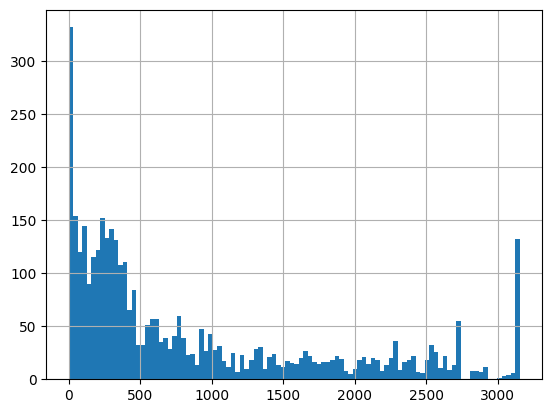

In [16]:
hist_distr.depthHistory.hist(bins=100)

In [17]:
(hist_distr.depthHistory//360).value_counts(normalize=True)

depthHistory
0    0.435724
1    0.171578
2    0.101173
3    0.053455
4    0.053194
7    0.048761
6    0.047197
5    0.046154
8    0.042764
Name: proportion, dtype: float64

In [18]:
df[IDCOL].value_counts().quantile([0,.25,.5,.8,.95,.99,1])

0.00       1.0
0.25      16.0
0.50      74.0
0.80     431.2
0.95    1143.6
0.99    2030.0
1.00    2635.0
Name: count, dtype: float64

- 80% of SKUs have a history that goes at best up to 4 years 
- 80% of SKUs have less than 400 observation on daily scale 

---> We'll assume that missing days registered 0 quantity sold 

---> We'll need a model that's capable of incorporating both short and long term patterns 

---> The model should have a mechanism to keep track of time (like positional encoding ) given that observations are not consecutive 


<Axes: xlabel='DATE'>

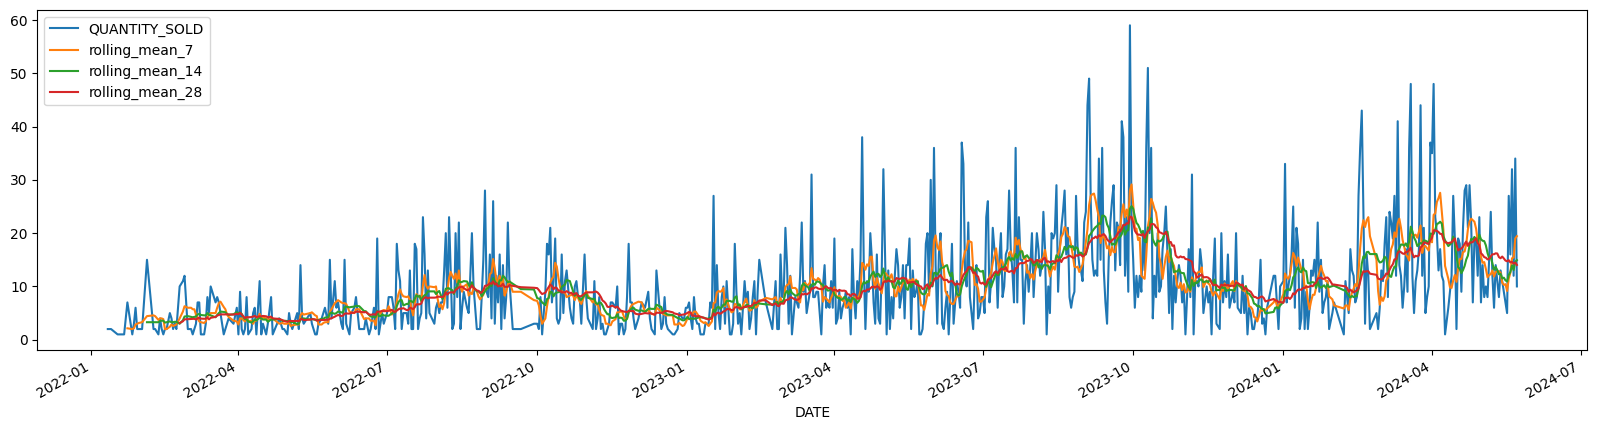

In [19]:
# random samples visualisation
rand_sample = df[df[IDCOL]==df[IDCOL].sample().values[0]].set_index(DATECOL)
rand_sample['rolling_mean_7']=rand_sample[TARGET].rolling(7).mean()
rand_sample['rolling_mean_14']=rand_sample[TARGET].rolling(14).mean()
rand_sample['rolling_mean_28']=rand_sample[TARGET].rolling(28).mean()
rand_sample[[TARGET,'rolling_mean_7','rolling_mean_14','rolling_mean_28']].plot(figsize=(20,5))

## Explore long term patterns

#### Inter-SKUs patterns

In [20]:
# We want to build a dataset indexed by [ month] , where all the observations coming from different SKU s are aligned to explore inter-relations , and yearly pattenrs accross SKUs
df[MONTHCOL]=df[DATECOL].dt.month
df[YEARCOL]=df[DATECOL].dt.year
grpd = df.groupby([IDCOL,YEARCOL,MONTHCOL],as_index=False)[CLEANTARGET].sum()
grpd.head(3)

,SKU,year,month,clean_QUANTITY_SOLD
0,-9222467576456937548,2022,3,5.0
1,-9222467576456937548,2022,4,7.0
2,-9222467576456937548,2022,5,13.0


In [21]:
corr_matrix = grpd.pivot_table(index=[YEARCOL,MONTHCOL],columns=[IDCOL],values=[CLEANTARGET]).dropna(axis=1, how='any').corr()
corr_matrix

clean_QUANTITY_SOLD  \
SKU                                      -9014563842186018972   
                    SKU                                         
clean_QUANTITY_SOLD -9014563842186018972             1.000000   
                    -8807033047177566203             0.445154   
                    -8680475692280947933             0.337956   
                    -8202557437824930196             0.418176   
                    -8096407053236906372             0.505162   
...                                                       ...   
                     8016119434425720999             0.556873   
                     8214975549353590820             0.544435   
                     8312262758630413740             0.526182   
                     8338563600818350034             0.438872   
                     8440467498849814369             0.395475   

                                                               \
SKU                                      -8807033047177566203   
                    SKU                                         
clean_QUANTITY_SOLD -9014563842186018972             0.445154   
                    -8807033047177566203             1.000000   
                    -8680475692280947933             0.559271   
                    -8202557437824930196             0.566191   
                    -8096407053236906372             0.214806   
...                                                       ...   
                     8016119434425720999             0.693829   
                     8214975549353590820             0.350846   
                     8312262758630413740             0.265695   
                     8338563600818350034             0.855815   
                     8440467498849814369             0.676670   

                                                               \
SKU                                      -8680475692280947933   
                    SKU                                         
clean_QUANTITY_SOLD -9014563842186018972             0.337956   
                    -8807033047177566203             0.559271   
                    -8680475692280947933             1.000000   
                    -8202557437824930196             0.914913   
                    -8096407053236906372             0.104289   
...                                                       ...   
                     8016119434425720999             0.477698   
                     8214975549353590820             0.261110   
                     8312262758630413740             0.272866   
                     8338563600818350034             0.770477   
                     8440467498849814369             0.516242   

                                                               \
SKU                                      -8202557437824930196   
                    SKU                                         
clean_QUANTITY_SOLD -9014563842186018972             0.418176   
                    -8807033047177566203             0.566191   
                    -8680475692280947933             0.914913   
                    -8202557437824930196             1.000000   
                    -8096407053236906372             0.314929   
...                                                       ...   
                     8016119434425720999             0.624552   
                     8214975549353590820             0.442618   
                     8312262758630413740             0.452511   
                     8338563600818350034             0.754006   
                     8440467498849814369             0.658371   

                                                               \
SKU                                      -8096407053236906372   
                    SKU                                         
clean_QUANTITY_SOLD -9014563842186018972             0.505162   
                    -8807033047177566203             0.214806   
                    -8680475692280947933             0.104289   
        

<Axes: xlabel='year,month'>

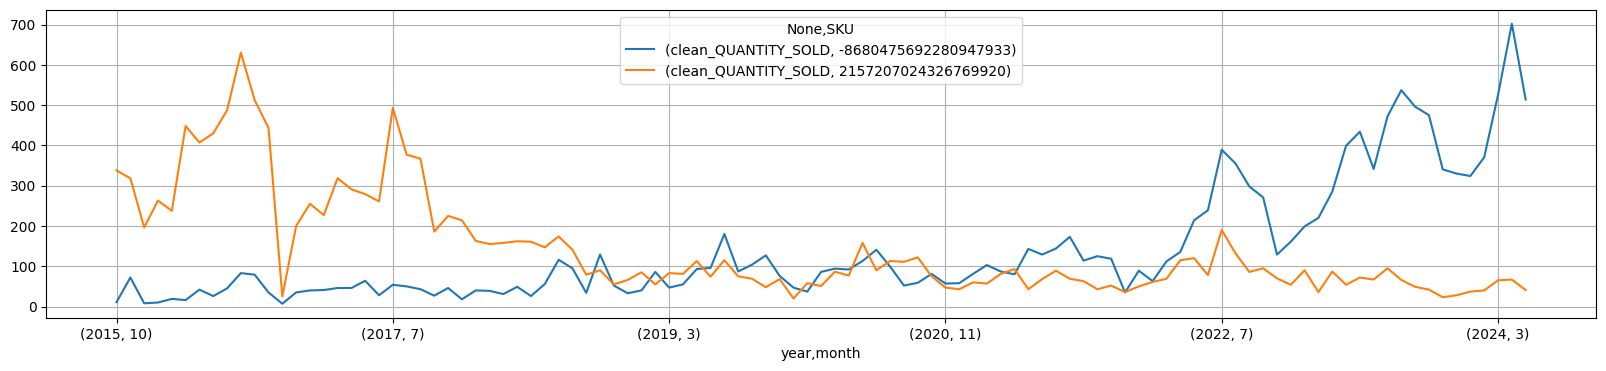

In [22]:
pair = [-8680475692280947933,2157207024326769920] #  -0.36 correlation coefficient
pd.pivot_table(grpd[grpd[IDCOL].isin(pair)],index=[YEARCOL,MONTHCOL],columns=[IDCOL],values=[CLEANTARGET]).dropna().plot(figsize=(20,4),grid=.4)

<Axes: xlabel='year,month'>

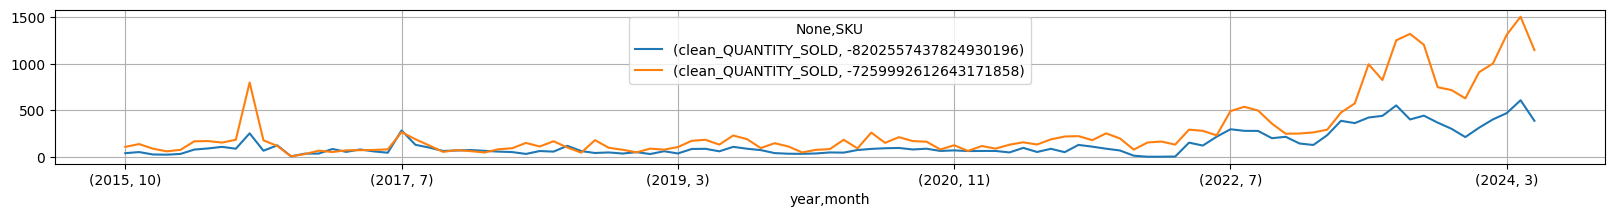

In [23]:
pair = [-8202557437824930196,-7259992612643171858] 
pd.pivot_table(grpd[grpd[IDCOL].isin(pair)],index=[YEARCOL,MONTHCOL],columns=[IDCOL],values=[CLEANTARGET]).dropna().plot(figsize=(20,2),grid=.4)

<Axes: xlabel='year,month'>

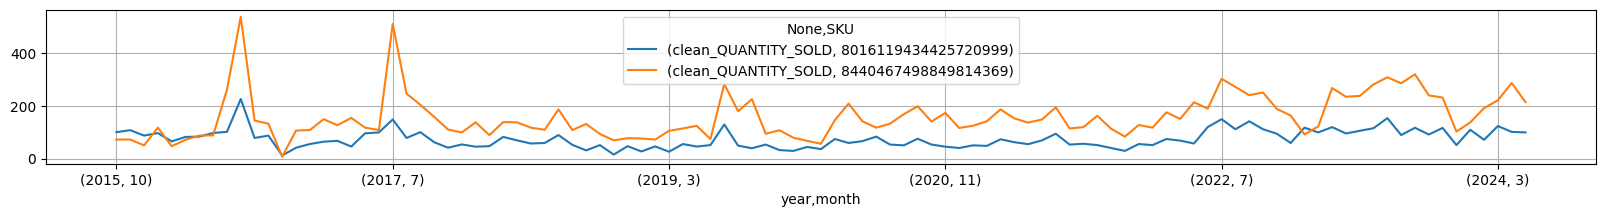

In [24]:
pair = [8440467498849814369,8016119434425720999] #  0.637586 correlation coefficient
pd.pivot_table(grpd[grpd[IDCOL].isin(pair)],index=[YEARCOL,MONTHCOL],columns=[IDCOL],values=[CLEANTARGET]).dropna().plot(figsize=(20,2),grid=.4)

In [25]:
# dropna here remove a column <=> sku for which there is not an available entry , missing values would corrupt the insights we're trying to infer 
grpd.pivot_table(index=MONTHCOL,columns=[IDCOL,YEARCOL],values=[CLEANTARGET]).dropna(axis=1, how='any')
grpd.head()

,SKU,year,month,clean_QUANTITY_SOLD
0,-9222467576456937548,2022,3,5.0
1,-9222467576456937548,2022,4,7.0
2,-9222467576456937548,2022,5,13.0
3,-9222467576456937548,2022,6,10.0
4,-9222467576456937548,2022,7,18.0


In [26]:
grpd = grpd.pivot_table(index=MONTHCOL,columns=[IDCOL,YEARCOL],values=[CLEANTARGET]).dropna(axis=1, how='any').T.reset_index().drop('level_0',axis=1)
grpd.columns = [IDCOL, YEARCOL]+[f"{MONTHCOL}_{i}" for i in np.arange(1,13)]
grpd.head(3)

,SKU,year,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-9222467576456937548,2023,6.0,10.0,9.0,18.0,31.5,17.0,26.0,19.0,11.0,10.0,12.0,14.0
1,-9204707410569096277,2017,116.0,80.0,76.0,125.0,86.0,67.0,193.0,124.0,72.0,75.0,43.0,68.0
2,-9204707410569096277,2018,48.0,33.0,48.0,51.0,47.0,101.0,232.0,154.0,104.0,99.0,40.0,46.0


In [27]:
grpd[TARGETYEAR]=grpd[[f"{MONTHCOL}_{i}" for i in np.arange(1,13)]].apply(lambda x :list(x),axis=1)
grpd.drop([f"{MONTHCOL}_{i}" for i in np.arange(1,13)],axis=1,inplace=True)
grpd.head(3)

,SKU,year,listed_year
0,-9222467576456937548,2023,"[6.0, 10.0, 9.0, 18.0, 31.5, 17.0, 26.0, 19.0,..."
1,-9204707410569096277,2017,"[116.0, 80.0, 76.0, 125.0, 86.0, 67.0, 193.0, ..."
2,-9204707410569096277,2018,"[48.0, 33.0, 48.0, 51.0, 47.0, 101.0, 232.0, 1..."


In [28]:
grpd[TARGETYEAR_1]=grpd.groupby(IDCOL)[TARGETYEAR].shift(1)
grpd.head(3)

,SKU,year,listed_year,listed_year_1
0,-9222467576456937548,2023,"[6.0, 10.0, 9.0, 18.0, 31.5, 17.0, 26.0, 19.0,...",NaN
1,-9204707410569096277,2017,"[116.0, 80.0, 76.0, 125.0, 86.0, 67.0, 193.0, ...",NaN
2,-9204707410569096277,2018,"[48.0, 33.0, 48.0, 51.0, 47.0, 101.0, 232.0, 1...","[116.0, 80.0, 76.0, 125.0, 86.0, 67.0, 193.0, ..."


In [29]:
grpd=grpd.dropna().reset_index(drop=True)
grpd.head(3)

,SKU,year,listed_year,listed_year_1
0,-9204707410569096277,2018,"[48.0, 33.0, 48.0, 51.0, 47.0, 101.0, 232.0, 1...","[116.0, 80.0, 76.0, 125.0, 86.0, 67.0, 193.0, ..."
1,-9204707410569096277,2019,"[91.0, 55.0, 78.0, 71.0, 118.0, 89.0, 308.5, 1...","[48.0, 33.0, 48.0, 51.0, 47.0, 101.0, 232.0, 1..."
2,-9204707410569096277,2020,"[46.0, 59.0, 90.0, 87.0, 89.0, 82.0, 75.0, 83....","[91.0, 55.0, 78.0, 71.0, 118.0, 89.0, 308.5, 1..."


In [30]:
grpd = df[[IDCOL,STATICOL]].drop_duplicates().merge(grpd)

#### SKU year to year patterns

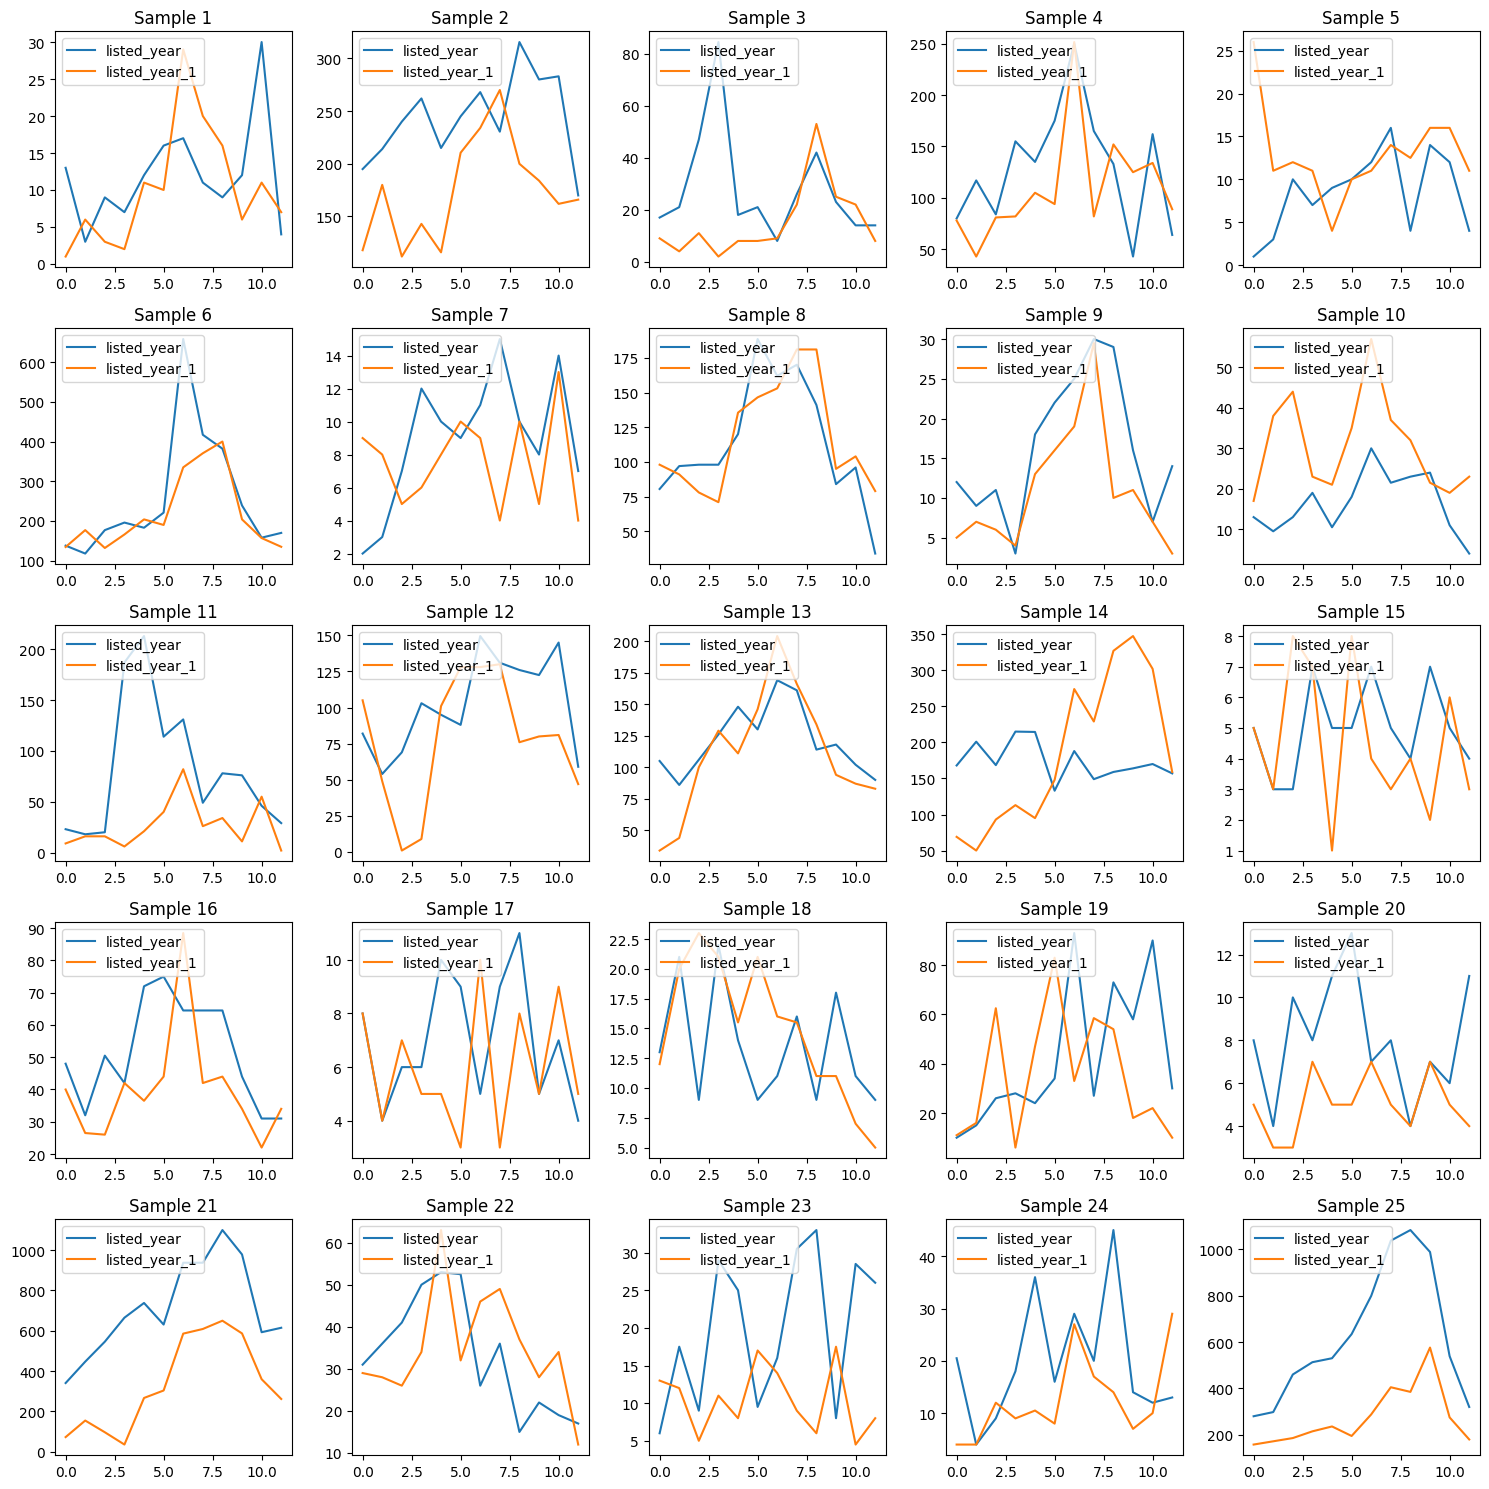

In [31]:
import matplotlib.pyplot as plt

def plot_predictions( n_samples=25, grid_size=(5, 5)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i in range(n_samples):
        spl = grpd.sample()
        target_year = spl[TARGETYEAR].values[0]
        target_year_1 = spl[TARGETYEAR_1].values[0]
        
        ax = axes[i]
        ax.plot(target_year, label=TARGETYEAR)
        ax.plot(target_year_1, label=TARGETYEAR_1)
        ax.set_title(f'Sample {i+1}')
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_predictions()

- We can notice obvious year to year patterns in many cases 